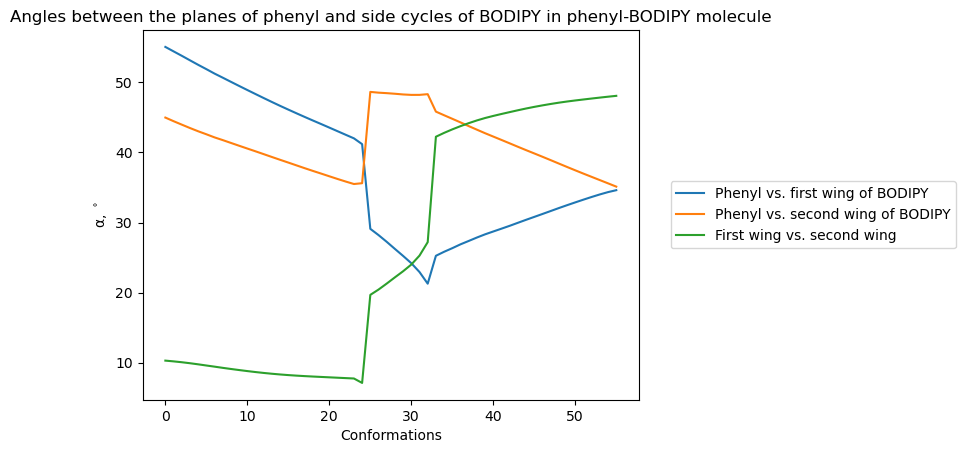

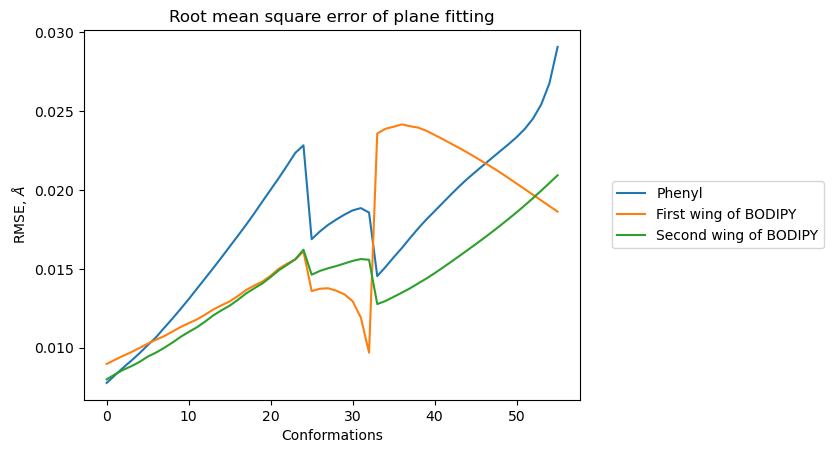

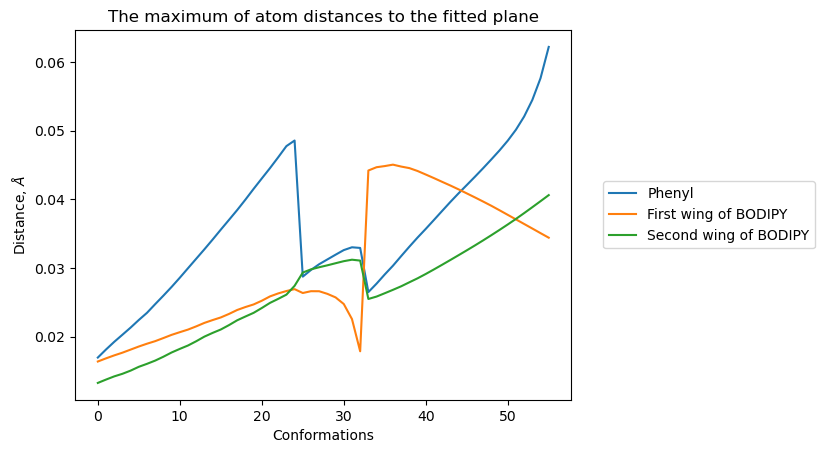

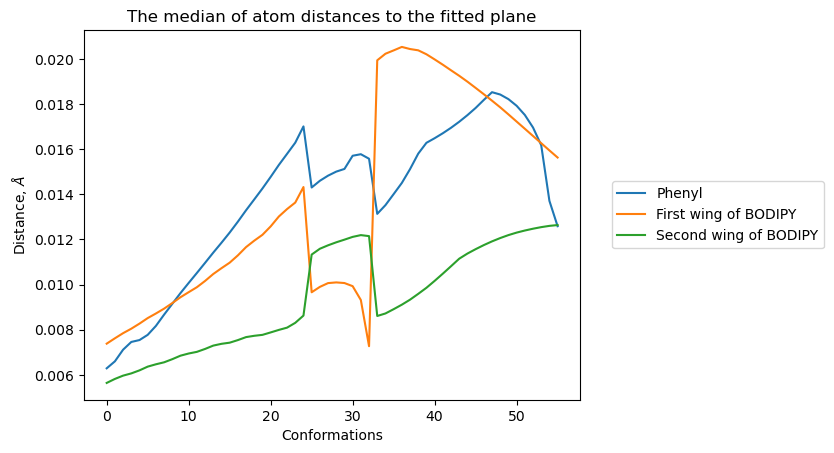

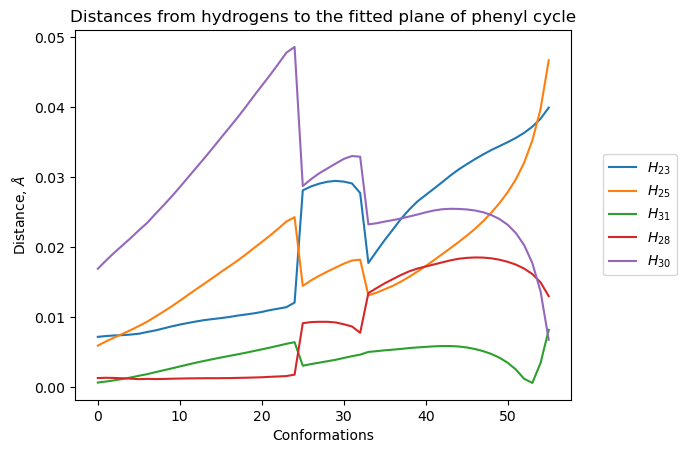

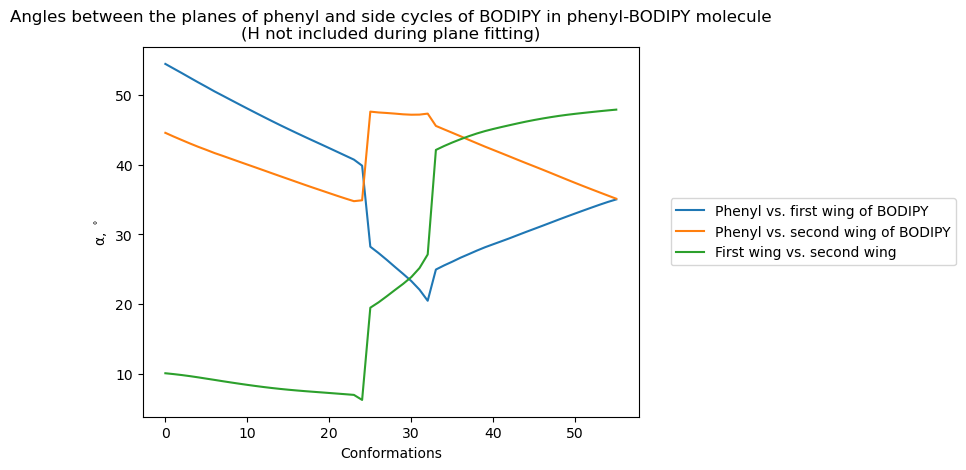

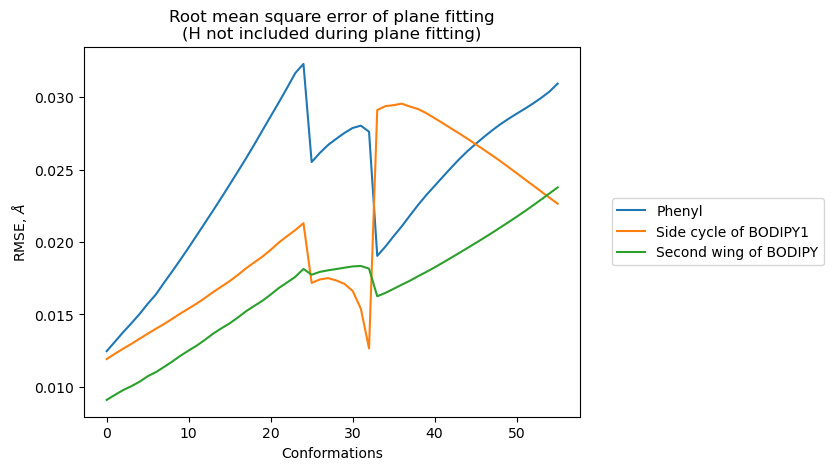

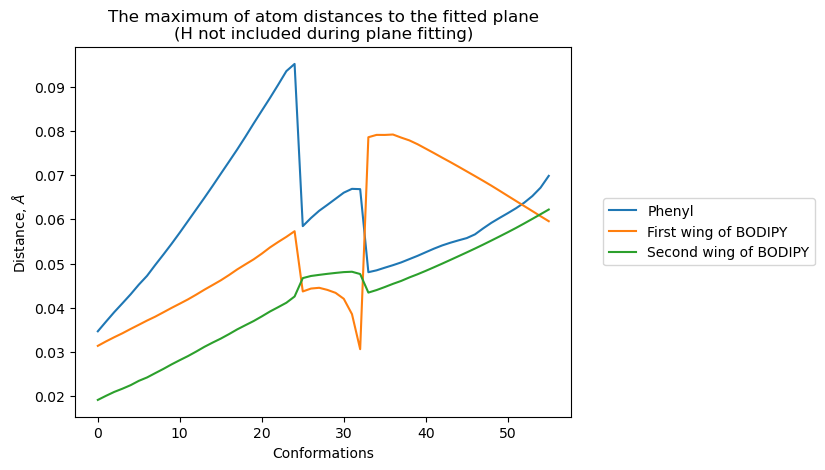

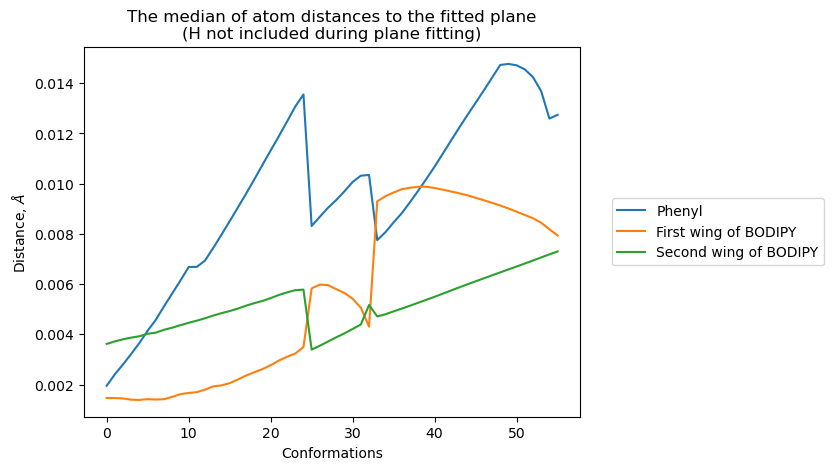

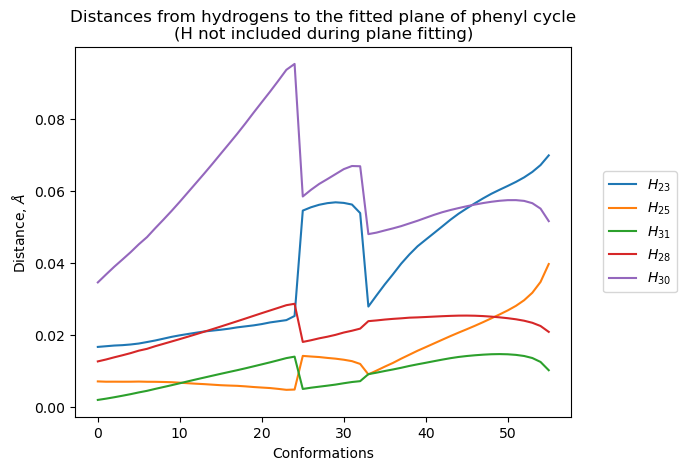

In [26]:
import numpy as np
import re
import math

# r, a, d in different contexts correspond to parameters related to distance (radius), angle and dihedral angle between atoms

def dc_from_gaussian_log (file_path, op="Optimized Parameters", m="Multiplicity",
                          gap=" ---------------------------------------------------------------------\n", 
                          mri="ModRedundant input"):
    """
    Reads optimized Decartian coordinates (e-06 angstrom precision) for each optimization configuration
    from a Gaussian .log file. Additionally, finds and reads the labels of the atoms.
    
    INPUT PARAMETERS:
    file_path - the path to the .log file;
    op, m, gap, mri - strings that help to navigate the .log file.
    
    OUTPUTS: 
    the coordinates and labels in np.arrays of shapes ATOMSxCONFIGSxXYZ and LABELS.
    """
    
    toggle1, toggle2, toggle3, n_iterations, coords, labels = 0, 0, 0, 0, [], []
    with open(file_path, 'r') as f:
        for line in reversed(list(f)):
            if op in line:
                toggle1 = not toggle1
                n_iterations += 1
            elif toggle1:
                if toggle2:
                    if gap == line: toggle1 = not toggle1
                    else:
                        coords += [line.split()[3], line.split()[4], line.split()[5]]
                if gap == line: toggle2 = not toggle2
            elif mri in line: toggle3 = not toggle3
            elif toggle3:
                if m in line: toggle3 = not toggle3
                elif line.split(): labels += [line.split()[0]]
    coordinate_array = np.empty((n_iterations, len(labels), 3))
    coordinate_array.flat[:] = coords
    
    return np.transpose(coordinate_array, [1, 0, 2])[::-1, ::-1, :], np.array(labels[::-1])

def ic_from_gaussian_log (file_path, r="! R", a="! A", d="! D", op="Optimized Parameters", m="Multiplicity"):
    """
    Reads optimized internal coordinates (e-04 angstrom/degree precision) from a Gaussian .log file.
    Additionally, finds and reads the coordinate labels and constructs a dictionary to make them more readable.
    
    INPUT PARAMETERS:
    file_path - the path to the .log file;
    r, a, d, op, m - strings that help to navigate the .log file.
    
    OUTPUTS: 
    the coordinates and labels in np.arrays of shapes COORDSxCONFIGS and LABELS.
    the dictionary that makes the labels more readable.
    """
    
    n_iterations, n_atoms, toggle, coords, labels = 0, 0, 0, [], []
    label_swap_dict = {"(": "(", ")": ")", ",": ",", "R": "r", "A": "θ", "D": "φ"}
    with open(file_path, 'r') as f:
        for line in f:
            if toggle:
                if not line.split(): toggle = not toggle
                else:
                    n_atoms += 1
                    label_swap_dict[str(n_atoms)] = "$" + str(line.split()[0]) + "_{" + str(n_atoms) + "}$"
            elif m in line: toggle = not toggle
            elif op in line: n_iterations += 1
            elif r in line or a in line or d in line:
                coords += [line.split()[3]]
                if n_iterations < 1:
                    labels += [line.split()[2]]
    coordinate_array = np.empty((n_iterations, len(labels)))
    coordinate_array.flat[:] = coords[len(labels):]
    
    return coordinate_array.T, np.array(labels), label_swap_dict

def twod_linear_regression (points):
    """
    Fits a plane through 3D points by finding the parameters a, b and c (z = ax + by + c).
    Uses linear regression generalized for planes rather than lines.
    
    INPUT PARAMETERS:
    points - np.array with point coordinates of the shape ATOMSxXYZ.
    
    OUTPUTS: 
    a tuple with the 3 parameters, a, b and c, that uniquely describe the plane.
    """
    
    points = points.T
    x, y, z = points[0], points[1], points[2]
    xm, ym, zm = np.mean(x), np.mean(y), np.mean(z)
    xs, ys, zs = x - xm, y - ym, z - zm
    xy = np.sum(x * ys) / np.sum(y * ys)
    a = np.sum((x - y * xy) * zs) / np.sum((x - y * xy) * xs)
    b = np.sum(y * (zs - a * xs)) / np.sum(y * ys)
    c = zm - a * xm - b * ym
    
    return (a, b, c)
    
def angle_between_planes (plane1, plane2, smaller_angle=True):
    """
    Finds the angle between 2 planes. Ignores the plane orientation, i. e. always picks the smaller of the 2 angles.
    Given the parametrization of the plane z = ax + by + c, the normal vector to this plane is n = [a, b, -1].
    The angle between the planes then follows from the scalar product of these normal vectors.
    
    INPUT PARAMETERS:
    plane1 and plane2 - tuples with the 3 parameters a, b and c describing the plane;
    smaller_angle - if set to True always picks the smaller angle between the planes.
    False value might be useful to see when the planes start bending in the opposite direction.
    
    OUTPUTS: 
    angle between the planes in degrees.
    """
    
    n1 = np.array([plane1[0], plane1[1], -1]) / (plane1[0] ** 2 + plane1[1] ** 2 + 1) ** 0.5
    n2 = np.array([plane2[0], plane2[1], -1]) / (plane2[0] ** 2 + plane2[1] ** 2 + 1) ** 0.5
    angle = math.acos(np.sum(n1*n2)) * 180 / math.pi
    if smaller_angle:
        if angle > 90: angle = 180 - angle
        
    return angle

def distance_from_point_to_plane (point, plane):
    """
    Finds the shortest distance from the point to the plane.
    
    INPUT PARAMETERS:
    point - a list with X, Y and Z coordinates;
    plane - tuple with the 3 parameters a, b and c describing the plane.
    
    OUTPUTS: 
    shortest distance between the point and the plane.
    """
    
    return abs(plane[0] * point[0] + plane[1] * point[1] - 1 * point[2] + plane[2]) / (plane[0] ** 2 + plane[1] ** 2 + 1) ** 0.5

def dists_to_plane_and_rmse (points, plane):
    """
    Finds the shortest distances from the points to the plane and the root mean square error (RMSE), i. e.
    how far on average the points are from the plane.
    
    INPUT PARAMETERS:
    points - np.array with point coordinates of the shape ATOMSxXYZ;
    plane - tuple with the 3 parameters a, b and c describing the plane.
    
    OUTPUTS: 
    shortest distances between the points and the plane in an one dimensional np.array;
    root mean square error.
    """
    
    distances = np.array([distance_from_point_to_plane(point, plane) for point in points])
    mean_square_error = np.sum(np.square(distances)) / len(distances)
    
    return distances, mean_square_error ** 0.5

def angle_jump_fix (coordinates, threshold=150):
    """
    Fixes angle jumping issue due to them being defined on [-180, 180] interval.
    
    INPUT PARAMETERS:
    coordinates - np.array with internal coordinates of the shape COORDSxCONFIGS;
    threshold - a heuristic value which defines above and below what angle values different configurations of the same
    angle have to be, so that shifting of the angle by 360 degrees is neccesary to avoid the angle jump.
    
    OUTPUTS: 
    the coordinates in a np.array of the shape COORDSxCONFIGS.
    """
    
    for i in range(coordinates.shape[0]): 
        if np.amin(coordinates[i, :]) < -threshold and np.amax(coordinates[i, :]) > threshold:
            for j in range(len(coordinates[i])):
                if coordinates[i, j] < 0: coordinates[i, j] += 360
                    
    return coordinates

def c_stats (coordinates):
    """
    Computes covariance matrix and standard deviations for all coordinates.
    
    INPUT PARAMETERS:
    coordinates - np.array with internal coordinates of the shape COORDSxCONFIGS.
    
    OUTPUTS: 
    2D and 1D np.arrays with the covariance matrix of the various internal coordinates
    and the standard deviations of each of them.
    """
    
    covariance_matrix = np.cov(coordinates)
    standard_deviations = np.sqrt(np.diag(covariance_matrix))
    
    return covariance_matrix, standard_deviations
    
def par_that_vary_most (std_devs, index_shift=0, threshold=0.5):
    """
    Returns indices of parameters that vary most. Only works with one kind of parameters.
    
    INPUT PARAMETERS:
    std_devs - a list of standard deviations of specific type coordinates;
    index_shift - the amount by which indices ought to be shifted to account for bond angles being listed after radii
    and dihedral angles being listed after bond angles;
    threshold - the fraction of the biggest standard deviation, that suffices for the coordinate to be considered
    varying a lot.
    
    OUTPUTS: 
    A list with indices of the coordinates with standard deviations above threshold * max(std_devs)
    """
    
    indices = []
    for i, element in enumerate(std_devs / np.amax(std_devs)):
        if element >= threshold:
            indices += [(i+index_shift)]
            
    return indices

def better_labels (labels, label_swap_dictionary):
    """
    Makes Gaussian internal coordinate labels more readable.
    
    INPUT PARAMETERS:
    labels - a list of Gaussian internal coordinate labels;
    label_swap_dictionary - a dictionary which explains how to swap every symbol in the regular internal coordinate labels.
    
    OUTPUTS: 
    A list with more readable labels.
    """
    
    return ["".join([label_swap_dictionary[l] for l in re.findall("[0-9]+|[^0-9]", label)]) for label in labels]

def coord_type_count (labels):
    """
    Counts the amount of distance, angle and dihedral angle coordinates.
    
    INPUT PARAMETERS:
    labels - a list of Gaussian internal coordinate labels.

    OUTPUTS: 
    A tuple with the amounts of radius, bond angle and dihedral angle like internal coordinates.
    """
    
    r, a = 0, 0
    for label in labels:
        if "r" in label: r += 1
        elif "θ" in label: a += 1
        else: break
            
    return (r, a, len(labels) - r - a)

def rescale_covariance_matrix (cov_mat, rt, rat):
    """
    Rescales submatrices of covariance matrix, that correspond to different mixes of internal coordinates, individually.
    
    INPUT PARAMETERS:
    cov_mat - covariance matrix of the various internal coordinates;
    rt - total amount of radii coordinates;
    rat - total amount of radii and bond angle coordinates.

    OUTPUTS: 
    A 2D np.array with normalized to 1 covariance matrix.
    """
    
    cov_mat[:rt, :rt] = cov_mat[:rt, :rt] / np.amax(cov_mat[:rt, :rt])
    cov_mat[rt:rat, :rt] = cov_mat[rt:rat, :rt] / np.amax(cov_mat[rt:rat, :rt])
    cov_mat[:rt, rt:rat] = cov_mat[rt:rat, :rt].T
    cov_mat[rat:, :rt] = cov_mat[rat:, :rt] / np.amax(cov_mat[rat:, :rt])
    cov_mat[:rt, rat:] = cov_mat[rat:, :rt].T
    cov_mat[rt:rat, rt:rat] = cov_mat[rt:rat, rt:rat] / np.amax(cov_mat[rt:rat, rt:rat])
    cov_mat[rat:, rt:rat] = cov_mat[rat:, rt:rat] / np.amax(cov_mat[rat:, rt:rat])
    cov_mat[rt:rat, rat:] = cov_mat[rat:, rt:rat].T
    cov_mat[rat:, rat:] = cov_mat[rat:, rat:] / np.amax(cov_mat[rat:, rat:])
    
    return cov_mat

def group_coords_by_cov (cov_mat, labels, threshold=0.9): #TODO should be a better way to do it
    """
    Sorts coordinate indices into bins judging by whether they describe the same atoms and whether they covariate enough.
    """
    
    bins, empty = [], 0
    atom_lists = atom_lists_from_labels(labels)
    for i in range(2, len(atom_lists)):
        for j in range(1, i):
            if threshold <= abs(cov_mat[i, j]):
                if not set(atom_lists[i]).isdisjoint(atom_lists[j]):
                    for b in range(len(bins)):
                        if i in bins[b] and j not in bins[b]: bins[b] += [j]
                        elif j in bins[b] and i not in bins[b]: bins[b] += [i]
                        elif i not in bins[b] and j not in bins[b]: empty += 1
                    if empty == len(bins): bins += [[i, j]]
                    empty = 0
                    
    return bins

def atom_lists_from_labels (labels): #TODO should be a better way to do it
    """
    Returns lists of numbers that specify which atoms are linked by specific internal coordinates.
    """
    
    return [re.findall(r'\d+', label) for label in labels]
    
def main(plot=1, internal=0, decartian=1):
    """
    Showcase of my progress.
    """
    
    if internal:
        coordinates, labels, label_swap_dictionary = ic_from_gaussian_log("bdp-phenyl-meoh-S1-fscan-fa.log")
        coordinates = angle_jump_fix(coordinates)
        labels = better_labels(labels, label_swap_dictionary)
        r_total, a_total, d_total = coord_type_count(labels)
        ra_total = r_total + a_total
        cov_mat, std_devs = c_stats(coordinates)
        cov_mat = rescale_covariance_matrix(cov_mat, r_total, ra_total)
        atom_bins = group_coords_by_cov(cov_mat, labels)

        if plot:
            import matplotlib.pyplot as plt
            plt.rcParams["figure.figsize"] = (7, 7)

            plt.imshow((cov_mat), cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.suptitle("Rescaled coordinate covariance matrix heatmap")
            plt.xlabel('Coordinate number')
            plt.ylabel('Coordinate number')
            plt.show()

            for abin in atom_bins:
                for c in abin:
                    plt.plot(coordinates[c] / np.amax(np.absolute(coordinates[c])), label=labels[c])
                plt.suptitle("Various normalized to unity coordinates grouped due to covariating enough and describing the same atoms")
                plt.xlabel('Iterations')
                plt.ylabel('Dimensionless values of internal coordinates')
                plt.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
                plt.show()

            """     

            #plt.plot(labels[:r_total], std_devs[:r_total])
            plt.plot(std_devs[:r_total])
            plt.suptitle("Standard deviations of bond lengths")
            plt.xlabel('Bond number')
            plt.ylabel('σ(r), r’$\AA$’')
            #plt.xticks(fontsize=8, rotation=90)   
            plt.show()

            #plt.plot(labels[r_total:r_total+a_total], std_devs[r_total:r_total+a_total])
            plt.plot(std_devs[r_total:ra_total])
            plt.suptitle("Standard deviations of bond angles")
            plt.xlabel('Bond angle number')
            plt.ylabel('σ(θ), $^\circ$')
            #plt.xticks(fontsize=8, rotation=90)
            plt.show()

            #plt.plot(labels[r_total+a_total:], std_devs[r_total+a_total:])
            plt.plot(std_devs[ra_total:])
            plt.suptitle("Standard deviations of dihedral angles")
            plt.xlabel('Dihedral angle number')
            plt.ylabel('σ(φ), $^\circ$')
            #plt.xticks(fontsize=8, rotation=90)
            plt.show()

            for p in par_that_vary_most(std_devs[:r_total]):
                plt.plot(coordinates[p], label=labels[p])
            plt.title("The dependence of bond lengths that change most on iterations")
            plt.xlabel("Conformations")
            plt.ylabel('r, $\AA$')
            plt.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
            plt.show()

            for i in par_that_vary_most(std_devs[r_total:ra_total], r_total):
                plt.plot(coordinates[i], label=labels[i])
            plt.title("The dependence of bond angles that change most on iterations")
            plt.xlabel("Conformations")
            plt.ylabel('θ, $^\circ$')
            plt.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
            plt.show()

            for i in par_that_vary_most(std_devs[ra_total:], ra_total):
                plt.plot(coordinates[i], label=labels[i])
            plt.title("The dependence of dihedral angles that change most on iterations")
            plt.xlabel("Conformations")
            plt.ylabel('φ, $^\circ$')
            plt.legend(loc="center left", bbox_to_anchor=(1.1, 0.5))
            plt.show()

            """
            
    if decartian:
        coords, labels = dc_from_gaussian_log("bdp-phenyl-meoh-S1-fscan-fa.log")
        
        """
        
        # Plots the planes fitted through the cyclic carbon chains and hydrogens
        i = 5
        group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
        plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
        a1, a2, a3 = angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)
        print("Angles (in degrees) between benzene plane and the planes of the 2 side cycles in Bodipy molecule:\n", a1, a2,
             "\nAngle (in degrees) between the 2 side cycles in Bodipy molecule:\n", a3)

            if plot:
                import matplotlib.pyplot as plt
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')

                x, y = np.meshgrid(np.linspace(-7, 7, 5), np.linspace(-7, 7, 5))
                z1, z2, z3 = plane1[0] * x + plane1[1] * y + plane1[2], plane2[0] * x + plane2[1] * y + plane2[2], plane3[0] * x + plane3[1] * y + plane3[2]

                ax.scatter(group1[:, 0], group1[:, 1], group1[:, 2], c="red")
                ax.plot_surface(x, y, z1, alpha=0.1, color="red")
                ax.scatter(group2[:, 0], group2[:, 1], group2[:, 2], c="blue")
                ax.plot_surface(x, y, z2, alpha=0.1, color="blue")
                ax.scatter(group3[:, 0], group3[:, 1], group3[:, 2], c="green")
                ax.plot_surface(x, y, z3, alpha=0.1, color="green")

                ax.set_xlim(-7, 7)
                ax.set_ylim(-7, 7)
                ax.set_zlim(-7, 7)
                plt.gca().view_init(10, 180)
                plt.show()
                
        """
        
        # Analysis fitting the plane through all atoms, i. e. hydrogen atoms included.
        
        angles, mses, dists1, dists2, dists3 = [], [], [], [], []
        for i in range(coords.shape[1]):
            group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
            plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
            angles += [[angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)]]
            dist1, mse1 = dists_to_plane_and_rmse(group1, plane1)
            dist2, mse2 = dists_to_plane_and_rmse(group2, plane2)
            dist3, mse3 = dists_to_plane_and_rmse(group3, plane3)
            dists1 += [dist1]
            dists2 += [dist2]
            dists3 += [dist3]
            mses += [[mse1, mse2, mse3]]
        angles, dists1, dists2, dists3, mses = np.array(angles), np.array(dists1), np.array(dists2), np.array(dists3), np.array(mses)
        
        if plot:
            import matplotlib.pyplot as plt
            
            plt.plot(angles.T[0], label="Phenyl vs. first wing of BODIPY")
            plt.plot(angles.T[1], label="Phenyl vs. second wing of BODIPY")
            plt.plot(angles.T[2], label="First wing vs. second wing")
            plt.title("Angles between the planes of phenyl and side cycles of BODIPY in phenyl-BODIPY molecule")
            plt.xlabel("Conformations")
            plt.ylabel("α, $^\circ$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
                
            plt.plot(mses.T[0], label="Phenyl")
            plt.plot(mses.T[1], label="First wing of BODIPY")
            plt.plot(mses.T[2], label="Second wing of BODIPY")
            plt.title("Root mean square error of plane fitting")
            plt.xlabel("Conformations")
            plt.ylabel("RMSE, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(np.amax(dists1, axis=1), label="Phenyl")
            plt.plot(np.amax(dists2, axis=1), label="First wing of BODIPY")
            plt.plot(np.amax(dists3, axis=1), label="Second wing of BODIPY")
            plt.title("The maximum of atom distances to the fitted plane")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(np.median(dists1, axis=1), label="Phenyl")
            plt.plot(np.median(dists2, axis=1), label="First wing of BODIPY")
            plt.plot(np.median(dists3, axis=1), label="Second wing of BODIPY")
            plt.title("The median of atom distances to the fitted plane")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            """            
            plt.plot(dists1.T[0, :], label="$C_{21}$ (C that connects phenyl to BODIPY)")
            plt.plot(dists1.T[3, :], label="$C_{24}$ (C connected to $H_{25}$)")
            plt.plot(dists1.T[5, :], label="$C_{26}$ (C opposite to $C_{21}$ and connected to $H_{31}$)")
            """
            plt.plot(dists1.T[2, :], label="$H_{23}$")
            plt.plot(dists1.T[4, :], label="$H_{25}$")
            plt.plot(dists1.T[10, :], label="$H_{31}$")
            plt.plot(dists1.T[7, :], label="$H_{28}$")
            plt.plot(dists1.T[9, :], label="$H_{30}$")
            plt.title("Distances from hydrogens to the fitted plane of phenyl cycle")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
        # Analysis fitting the plane through carbon and nitrogen atoms only, but including hydrogens for error estimation.
        
        angles, mses, dists1, dists2, dists3 = [], [], [], [], []
        for i in range(coords.shape[1]):
            group1 = np.array([coords[20, i, :], coords[21, i, :], coords[23, i, :], coords[25, i, :], coords[26, i, :], coords[28, i, :]])
            group2 = np.array([coords[1, i, :], coords[2, i, :], coords[4, i, :], coords[6, i, :], coords[8, i, :]])
            group3 = np.array([coords[10, i, :], coords[11, i, :], coords[13, i, :], coords[15, i, :], coords[17, i, :]])
            plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
            group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
            angles += [[angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)]]
            dist1, mse1 = dists_to_plane_and_rmse(group1, plane1)
            dist2, mse2 = dists_to_plane_and_rmse(group2, plane2)
            dist3, mse3 = dists_to_plane_and_rmse(group3, plane3)
            dists1 += [dist1]
            dists2 += [dist2]
            dists3 += [dist3]
            mses += [[mse1, mse2, mse3]]
        angles, dists1, dists2, dists3, mses = np.array(angles), np.array(dists1), np.array(dists2), np.array(dists3), np.array(mses)
        
        if plot:
            import matplotlib.pyplot as plt
            
            plt.plot(angles.T[0], label="Phenyl vs. first wing of BODIPY")
            plt.plot(angles.T[1], label="Phenyl vs. second wing of BODIPY")
            plt.plot(angles.T[2], label="First wing vs. second wing")
            plt.title("Angles between the planes of phenyl and side cycles of BODIPY in phenyl-BODIPY molecule\n(H not included during plane fitting)")
            plt.xlabel("Conformations")
            plt.ylabel("α, $^\circ$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
                
            plt.plot(mses.T[0], label="Phenyl")
            plt.plot(mses.T[1], label="Side cycle of BODIPY1")
            plt.plot(mses.T[2], label="Second wing of BODIPY")
            plt.title("Root mean square error of plane fitting\n(H not included during plane fitting)")
            plt.xlabel("Conformations")
            plt.ylabel("RMSE, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(np.amax(dists1, axis=1), label="Phenyl")
            plt.plot(np.amax(dists2, axis=1), label="First wing of BODIPY")
            plt.plot(np.amax(dists3, axis=1), label="Second wing of BODIPY")
            plt.title("The maximum of atom distances to the fitted plane\n(H not included during plane fitting)")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(np.median(dists1, axis=1), label="Phenyl")
            plt.plot(np.median(dists2, axis=1), label="First wing of BODIPY")
            plt.plot(np.median(dists3, axis=1), label="Second wing of BODIPY")
            plt.title("The median of atom distances to the fitted plane\n(H not included during plane fitting)")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            """
            plt.plot(dists1.T[0, :], label="$C_{21}$ (C that connects phenyl to BODIPY)")
            plt.plot(dists1.T[3, :], label="$C_{24}$ (C connected to $H_{25}$)")
            plt.plot(dists1.T[5, :], label="$C_{26}$ (C opposite to $C_{21}$ and connected to $H_{31}$)")
            """
            plt.plot(dists1.T[2, :], label="$H_{23}$")
            plt.plot(dists1.T[4, :], label="$H_{25}$")
            plt.plot(dists1.T[10, :], label="$H_{31}$")
            plt.plot(dists1.T[7, :], label="$H_{28}$")
            plt.plot(dists1.T[9, :], label="$H_{30}$")
            plt.title("Distances from hydrogens to the fitted plane of phenyl cycle\n(H not included during plane fitting)")
            plt.xlabel("Conformations")
            plt.ylabel("Distance, $\AA$")
            plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
            plt.show()
    
def test():
    """
    For testing the outputs of the functions.
    """
    print("Plane parameter search test:")
    plane = twod_linear_regression(np.array([[0, 0, 5], [0, 1, 5], [1, 1, 5]]))
    print("Expected vs. computed outputs:\n(0.0, 0.0, 5.0) vs. "+ str(plane))
    print("\nPoint distance to plane test:")
    print("Expected vs. computed outputs:\n3.0 vs. " + str(distance_from_point_to_plane([0, 0, 2], plane))) 
    
    
if __name__ == "__main__":
    main()
    #test()